# Introduction

Cardiovascular Disease (CVD) is the "number one cause of death worldwide", having "almost 17.9 million deaths occurring" per year. CVD in many cases if treatment is given early the risk factor is greatly reduced. CVD also has many causing factors and therefore to make a accurate study huge amount of data needs to be collected (Princy, R.J.P. et al) (Ali, M.M. et al).

It is a perfect opportunity for machine learning, which becomes more accurate with more data. I have chosen to illustrate a convulsion neural network (CNN) by using a reduced heart disease dataset from "Rousseauw et al, 1983, South African Medical Journal".

# Method

## Install Libraries

In [ ]:
%pip install tensorflow==2.8.0
%pip install liac-arff==2.5.0
%pip install pandas==1.4.2
%pip install scikit-learn==1.0.2
%pip install matplotlib==3.5.1
%pip install seaborn==0.11.2

## Imports
First we will import required libraries.

- liac-arff is used to process arff files
- matplotlib & seaborn is used to output result graphs
- scikit-learn is used to assist with dataset preparation for machine learning
- tensorflow is used to build, train and test models
- pandas is used to load csv data into a dataframe for in-memory manipulation

In [4]:
from pathlib import Path
from urllib.request import urlopen

import arff
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import pandas as pd

## Variables
Here we will set up some constant variables to be shared with various processes.

In [5]:
DATA_SET_URL = "https://www.openml.org/data/download/1592290/phpgNaXZe"
ARFF_FILE_NAME = "dataset.arff"
CSV_FILE_NAME = "dataset.csv"
CSV_HEADER = "sbp,tobacco,ldl,adiposity,famhist,type,obesity,alcohol,age,chd"

## Download Dataset
First we will need to download the dataset from OpenML. This section of code will download it to write it to disk.

When downloading the dataset a few extra white space characters are added so this code removes any by using the `strip()` function.

Before downloading a check will be run to skip this if the file already exists.

In [6]:
if not Path(ARFF_FILE_NAME).exists():
    with urlopen(DATA_SET_URL) as response:
        content = response.read()
        with open(ARFF_FILE_NAME, "wb") as fo:
            fo.write(content.strip())

## Load Dataset

The following code will load the arff data into memory using the "liac-arff" library. This is required as the data is given as an arff file.

In [7]:
with open(ARFF_FILE_NAME) as fo:
    arff_dataset = arff.load(fo)

## Convert To CSV
To use this dataset with tensorflow we need to convert it to a csv file. This code creates a csv file places a predefined header (which matches the attribute names). Then we access the "data" field of the dataset, which is provided as a list which we then join into a string separating each column with a "," and ending each row with "\n", which is the newline character. This csv file will then be written to disk.

Before processing a new csv file; a check will be run to skip this if the file already exists.

In [8]:
if not Path(CSV_FILE_NAME).exists():
    data = arff_dataset["data"]

    with open(CSV_FILE_NAME, "wt") as fo:
        fo.write(CSV_HEADER + "\n")
        for row in data:
            fo.write(",".join([str(col) for col in row]) + "\n")

## Load CSV
To load it into tensorflow we need to read the csv data into a pandas data-frame, this allows for the data to be manipulated in memory easily.

To load the "x" coordinate data, which will be the inputs, we will use pandas `get_dummies()` method, which will convert the data into a format for tensor flow and dropping the output column.

Then we will store the output column as "y" which has the header name of "chd".

In [9]:
df = pd.read_csv(CSV_FILE_NAME)

x = pd.get_dummies(df.drop(['chd'], axis=1))
y = df["chd"]

As our data is now loaded, we can use sklearn's `train_test_split()` method, which will allow us to split our data into two section, one for training and the other for testing. I have selected to keep 20% for testing leaving 80% for training.

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2)

This is a sample output of our training data "x" rows

In [11]:
x_train.head()

,sbp,tobacco,ldl,adiposity,famhist,type,obesity,alcohol,age
258,138.0,12.00,5.13,28.34,2,59.0,24.49,32.81,58.0
242,190.0,4.18,5.05,24.83,2,45.0,26.09,82.85,41.0
406,180.0,25.01,3.70,38.11,1,57.0,30.54,0.00,61.0
121,120.0,1.40,6.25,20.47,2,60.0,25.85,8.51,28.0
128,134.0,8.80,7.41,26.84,2,35.0,29.44,29.52,60.0


This is a sample output of our training data "y" rows.

In [12]:
y_train.head()

258    2
242    1
406    2
121    1
128    2
Name: chd, dtype: int64

## Create Model
Now our data is loaded and processed, we need to make our CNN models. As our dataset is numerical I am using the `Sequential` model from Keras.

The first layer of our network will be the input, it will have two nodes as that is the number of classes in our dataset. The number of inputs will match the length of our columns from the dataset.

We will use one hidden layer as we are working with linear relationships. We will also set the number of nodes to sixteen.

The last layer will be our output, because we want a true/false output the number of nodes has been set to one. It will also use a sigmoid function as we want a predication value of whether it is likely true or false.

In [41]:
model = Sequential()
model.add(Dense(units=2, activation='relu', input_dim=len(x_train.columns)))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

Here we compile the model. We will calculate loss using `binary_crossentropy`. We have chosen to use Binary Cross Entropy as it calculates the loss between predicted true and false labels. As our output layer of our model is either true/false it is well suited.

We will use `sgd` for the optimizer, which will allow the changing of weights and learning rates to reduce losses. I have chosen to use the stochastic gradient descent optimizer as it requires less memory and converges in less time due to frequent updates to model parameters.

We will also request that metric data for accuracy to be shown during fitting so we can see the progress of the training.

In [42]:
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics='accuracy')

Here we can see a summary of how our model is constructed.

In [43]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 2)                 20        
                                                                 
 dense_10 (Dense)            (None, 16)                48        
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 85
Trainable params: 85
Non-trainable params: 0
_________________________________________________________________


## Train Model
Here we train the model, specifying that we want 4 epochs as we don't have much data to train with and we don't want to over-fit our model.

Multiprocessing is also specified which will allow full utilisation of all CPU cores.

In [52]:
model.fit(x_train, y_train, epochs=4, use_multiprocessing=True)

Epoch 1/4
12/12 [==============================] - 0s 680us/step - loss: nan - accuracy: 0.0000e+00
Epoch 2/4
12/12 [==============================] - 0s 705us/step - loss: nan - accuracy: 0.0000e+00
Epoch 3/4
12/12 [==============================] - 0s 684us/step - loss: nan - accuracy: 0.0000e+00
Epoch 4/4
12/12 [==============================] - 0s 790us/step - loss: nan - accuracy: 0.0000e+00


## Test Model
Now the model has been trained we can test it using our test data. We will use the `predict()` method to pass in our test data and get out a predication. We will then convert the accuracy values to true/false.

In [53]:
y_predication = model.predict(x_test)
y_predication = [0 if val < 0.5 else 1 for val in y_predication]

## Calculate Accuracy

In [54]:
accuracy = accuracy_score(y_test, y_predication)

print(round(accuracy * 100, 4), "% Accurate")

63.4409 % Accurate


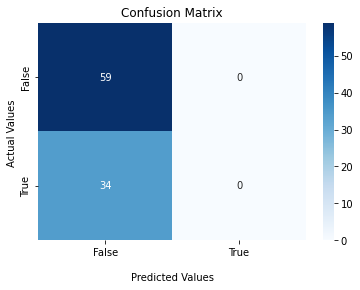

In [55]:
confusion = confusion_matrix(y_test, y_predication)

ax = sns.heatmap(confusion, annot=True, cmap='Blues')
ax.set_title("Confusion Matrix")
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

# Conclusion

In conclusion we can see that our model is ~60% accurate, while this is quite low we don't have much data only around 400 rows. As we have used a reduced dataset, accuracy could be improved by simply increasing the amount of rows of data which we could get in the same format from the original (unreduced) dataset. We chose to use the reduced dataset as a large amount of data would take longer to train and for testing purposes a smaller amount makes it easier for experimenting with different hidden layer configurations. We could also change to use a different dataset which could include more attributes allowing a more realistic predication. For example other studies such as Beunza, J.J. et al used the "Framingham Heart Study" which had "4000+" observations and got an accuracy value of ~85% on some configurations. Sharma, V. et al who used the Cleveland dataset and used 14 attributes and 1025 instances got similar results depending on the configuration and algorithm used.

There are many machine learning methods that can be used that may be better for accuracy other than a Artificial Neural Network. For example Decision Tree (DT) matches groups of data into a tree structure, Random Forest (RF) also creates a tree like structure. K-Nearest Neighbour (KNN) makes predictions based on neighbours. Lots of experiments by different people have been carried out to find out which one is most accurate. Ali's experiments found that they all produced higher than 80%. However, most of these algorithms (DT, RF) performed badly without a large dataset, apart from KNN which performed better with small amounts of data (Princy, R.J.P. et al) (Ali, M.M. et al).

When using machine learning with medical data, there are many ethical and legal considerations. One of these is racial & gender injustice which is when datasets are biased to a certain race/group or gender which causing inaccurate predications, this could be prevented by ensuring that captured data is diverse to include everyone to prevent any bias. A legal issue is the collecting of personal medical data and using it for processing, this can be easily be prevented by ensuring everyone signs that they are willing to give their information away (Chen, I.Y. et al).

# References
- Princy, R.J.P., Parthasarathy, S., Jose, P.S.H., Lakshminarayanan, A.R. and Jeganathan, S., 2020, May. Prediction of cardiac disease using supervised machine learning algorithms. In 2020 4th International Conference on Intelligent Computing and Control Systems (ICICCS) (pp. 570-575). IEEE.
- Ali, M.M., Paul, B.K., Ahmed, K., Bui, F.M., Quinn, J.M. and Moni, M.A., 2021. Heart disease prediction using supervised machine learning algorithms: performance analysis and comparison. Computers in Biology and Medicine, 136, p.104672.
- Beunza, J.J., Puertas, E., García-Ovejero, E., Villalba, G., Condes, E., Koleva, G., Hurtado, C. and Landecho, M.F., 2019. Comparison of machine learning algorithms for clinical event prediction (risk of coronary heart disease). Journal of biomedical informatics, 97, p.103257.
- Sharma, V., Yadav, S. and Gupta, M., 2020, December. Heart disease prediction using machine learning techniques. In 2020 2nd International Conference on Advances in Computing, Communication Control and Networking (ICACCCN) (pp. 177-181). IEEE.
- Chen, I.Y., Pierson, E., Rose, S., Joshi, S., Ferryman, K. and Ghassemi, M., 2021. Ethical machine learning in healthcare. Annual Review of Biomedical Data Science, 4, pp.123-144.

# Appendices
## Source Code
- <https://github.com/enchanted-code/python-cnn>
